In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el fichero csv
df = pd.read_csv ("reto_agua.csv")

#Configuramos pandas para que muestre todas las columnas
pd.set_option('display.max_columns', None)

#creamos una variable global que usaremos más adelante
global resultados

# Transformamos columnas object en categóricas
columns_object = df.loc[:, df.dtypes == object].columns

for column in columns_object:
  df[column] = df[column].astype("category") # Convertimos a categoría

#Observamos los valores Nulos. Si no son representativos, podemos eliminarlos del dataframe.
df.isnull().sum()

#Eliminamos los datos nulos
df = df.dropna()

#Eliminamos las columnas innecesarias (Tienen un solo valor único, todos sus valores son distintos o son redundantes)
df[["water_quality", "quality_group"]].head(50) #Son columnas que tienen los mismos datos. Eliminamos la columna quality_group
df = df.drop(columns=["wpt_name", "id", "recorded_by", "quality_group"])
df.nunique()
df.duplicated().sum()

#Eliminamos los duplicados
df = df.drop_duplicates()
df.duplicated().sum()

# Transformar variables categóricas en numéricas usando LabelEncoder
columns_category = df.select_dtypes(include=['category']).columns

label_encoders = {}
for col in columns_category:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
df


,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management_group,payment_type,water_quality,quantity_group,source_class,waterpoint_type_group,status_group
0,6000.0,1103,1390,1226,34.938093,-9.856322,0,1,3,109,1,6,0,1999,3,4,0,6,1,0,1,0
2,25.0,685,686,1675,37.460664,-3.821329,0,5,8,250,1,6,1,2009,3,4,5,6,1,1,1,0
3,0.0,1416,263,1506,38.486161,-11.155298,0,7,12,58,1,6,1,1986,14,4,2,6,0,0,1,1
5,20.0,803,0,318,39.172796,-4.765587,0,5,20,1,1,6,1,2009,14,4,5,4,1,2,1,0
6,0.0,286,0,329,33.362410,-3.766365,0,0,17,0,1,6,1,0,15,4,2,6,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55077,500.0,1520,351,849,37.634053,-6.124830,0,8,11,89,1,6,1,2007,14,4,1,6,1,0,1,1
55078,10.0,369,1210,158,37.169807,-3.253847,0,5,6,125,1,9,1,1999,3,4,5,6,1,0,1,0
55079,4700.0,139,1212,210,35.249991,-9.070629,0,6,3,56,1,6,1,1996,3,4,0,6,1,1,1,0
55081,0.0,725,0,987,35.861315,-6.378573,0,6,2,0,1,6,1,0,8,4,2,6,2,0,3,0


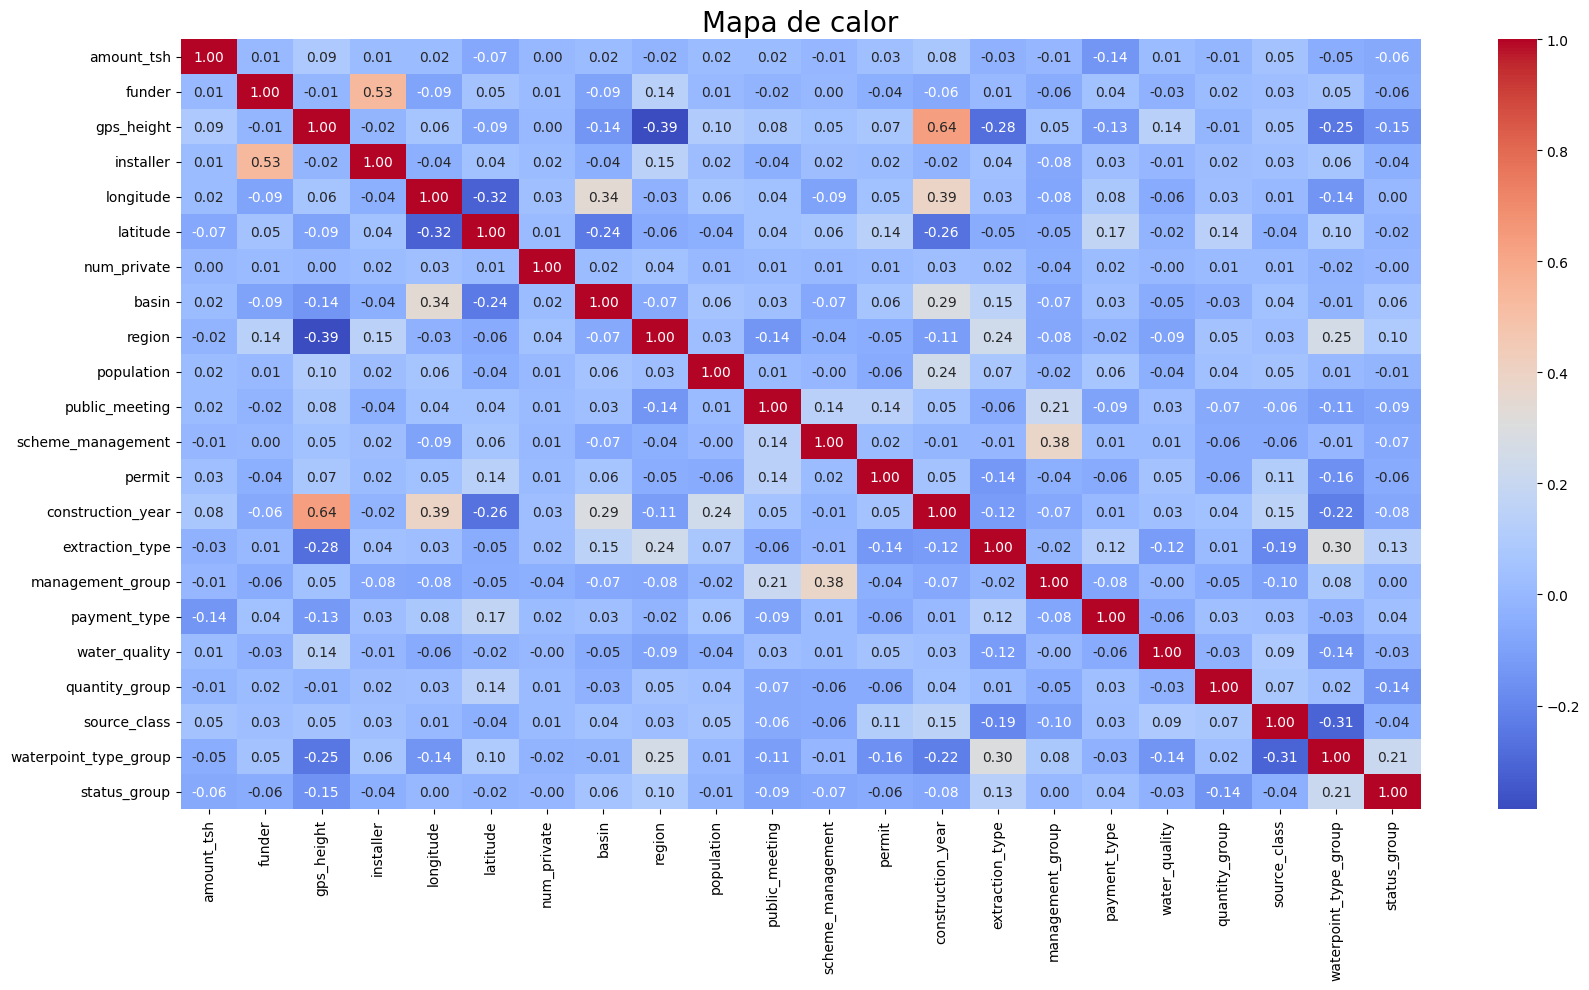

In [35]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Mapa de calor', fontsize = 20)
plt.show()

In [36]:
#Eliminamos las columnas que no tienen relación con nuestra variable objetivo, a excepción de longitud
df = df.drop(columns = ["management_group", "num_private"])

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Define una función llamada 'crea_modelos' y declara que usará las variables globales 'df_banco' y 'resultados'
def crea_modelos():
  global resultados
  y = df['status_group']
  X = df.drop(columns='status_group')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)

  models = {
      'Regresión Logística': LogisticRegression(),
      'Árbol de Decisión': DecisionTreeClassifier(),
      'Random Forest': RandomForestClassifier(),
      'Naive Bayes': GaussianNB()
  }

# Inicializa un diccionario llamado 'results' para almacenar los nombres de los modelos y varias métricas de evaluación para cada uno
  results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'AUC-ROC': []}

#Itera sobre cada par nombre-modelo en el diccionario 'models'
  for name, model in models.items():
      # Entrena el modelo
      model.fit(X_train, y_train)
      # Realiza las predicciones en el conjunto de prueba
      predictions = model.predict(X_test)
      accuracy = accuracy_score(y_test, predictions)
      precision = precision_score(y_test, predictions)
      recall = recall_score(y_test, predictions)
      f1 = f1_score(y_test, predictions)
      if hasattr(model, "predict_proba"):
          proba = model.predict_proba(X_test)
          roc_auc = roc_auc_score(y_test, proba[:, 1])
      else:
          roc_auc = None

      # Añade el nombre del modelo a la lista correspondiente en el diccionario 'results'
      results['Model'].append(name)

      # Añade la precisión a la lista correspondiente en el diccionario 'results'
      results['Accuracy'].append(accuracy)

      # Añade la precisión (precision) a la lista correspondiente en el diccionario 'results'
      results['Precision'].append(precision)

      # Añade la sensibilidad (recall) a la lista correspondiente en el diccionario 'results'
      results['Recall'].append(recall)

      # Añade la puntuación F1 a la lista correspondiente en el diccionario 'results'
      results['F1-score'].append(f1)

      # Añade la puntuación AUC-ROC a la lista correspondiente en el diccionario 'results'
      results['AUC-ROC'].append(roc_auc)

# Asigna el diccionario 'results' a la variable global 'resultados'
  resultados = results
crea_modelos()

c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
#Recorremos la lista resultados 
for i,model in enumerate(resultados['Model']):
  print(model)
  print(f"Accuracy: {resultados['Accuracy'][i]:.2f}")
  print(f"Precision: {resultados['Precision'][i]:.2f}")
  print(f"Recall: {resultados['Recall'][i]:.2f}")
  print(f"F1-score: {resultados['F1-score'][i]:.2f}")
  print(f"AUC-ROC: {resultados['AUC-ROC'][i]:.2f}")
  print('\n')

Regresión Logística
Accuracy: 0.64
Precision: 0.58
Recall: 0.41
F1-score: 0.48
AUC-ROC: 0.66


Árbol de Decisión
Accuracy: 0.81
Precision: 0.77
Recall: 0.78
F1-score: 0.77
AUC-ROC: 0.81


Random Forest
Accuracy: 0.86
Precision: 0.86
Recall: 0.78
F1-score: 0.82
AUC-ROC: 0.92


Naive Bayes
Accuracy: 0.60
Precision: 0.51
Recall: 0.75
F1-score: 0.61
AUC-ROC: 0.70




In [39]:
import numpy
columnas = df.columns
# Función para detectar outliers usando el método IQR
def has_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #agregamos una condición OR y aplicamos shape[0] que nos devuelve el número de filas que cumplen la condición. Devolverá True si hay outliers
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0] > 0

#Identificar columnas con outliers
columns_with_outliers = [column for column in columnas if has_outliers(df, column)]

#Imprimir las columnas con outliers
print("Columnas con outliers:", columns_with_outliers)




Columnas con outliers: ['amount_tsh', 'installer', 'longitude', 'population', 'public_meeting', 'scheme_management', 'extraction_type', 'water_quality', 'quantity_group', 'source_class']


Shape of the DataFrame after removing outliers: (38991, 20)


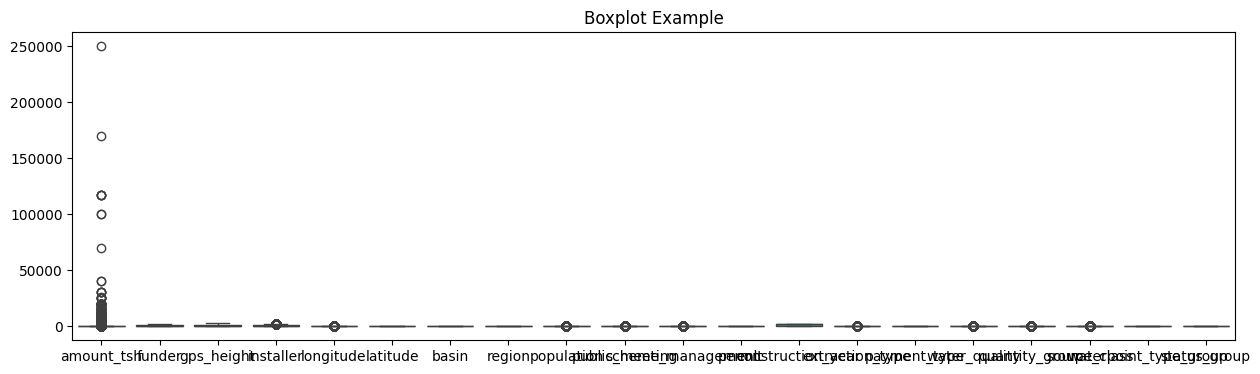

In [41]:
# Función para eliminar outliers usando el método IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered
#Eliminamos outliers de las columnas population y gps_height
columnas_para_eliminar_outliers= ['population', "gps_height"]

# Aplicar la función a cada columna
for column in columnas_para_eliminar_outliers:
    df = remove_outliers(df, column)

# Paso 4: (Opcional) Verificar los resultados
print("Shape of the DataFrame after removing outliers:", df.shape)

# Crear el boxplot
plt.figure(figsize=(15, 4))
sns.boxplot(df)
plt.title('Boxplot Example')
plt.show()

In [51]:
#Dividimos el dataset en variables   
X = df.drop('status_group', axis=1)  # Variables independientes
y = df['status_group']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Entrenar el modelo Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predecir con el conjunto de prueba y calcular la precisión
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
if hasattr(clf, "predict_proba"):
    proba = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, proba[:, 1])
else:
    roc_auc = None
print(f"Accuracy Random Forest: {accuracy:.2f}")
print(f"Precisión Random Forest: {precision:.2f}")
print(f"Recall Random Forest: {recall:.2f}")
print(f"F1 Random Forest: {f1:.2f}")
print(f"AUC Random Forest: {roc_auc:.2f}")

Accuracy Random Forest: 0.87
Precisión Random Forest: 0.87
Recall Random Forest: 0.79
F1 Random Forest: 0.83
AUC Random Forest: 0.93


El modelo Random Forest es adecuado para este proyecto debido a su excelente desempeño en múltiples métricas de evaluación. Con una exactitud del 87%, el modelo demuestra una alta capacidad para clasificar correctamente las instancias en el conjunto de prueba. La precisión del 87% indica que el modelo tiene una baja tasa de falsos positivos, lo cual es crucial en escenarios donde los errores de tipo I (falsos positivos) pueden ser costosos o indeseables. El recall del 79% muestra que el modelo es competente en la identificación de las instancias positivas, aunque hay margen para mejorar en la captura de todos los verdaderos positivos. El F1 Score del 83% refleja un buen balance entre precisión y recall, asegurando un desempeño robusto en general. Finalmente, con un AUC-ROC de 0.93, el modelo exhibe una excelente capacidad discriminativa, lo que significa que puede diferenciar eficazmente entre clases positivas y negativas. En resumen, el Random Forest proporciona una combinación balanceada de alta exactitud, precisión, recall y capacidad discriminativa, lo que lo hace una elección confiable y efectiva para el proyecto.